[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/edit-state-human-feedback.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239520-lesson-3-editing-state-and-human-feedback)

# Editing graph state

## Review

ヒューマンインザループ(human-in-the-loop)の動機について議論しました：

(1) `Approval` - エージェントを中断し、ユーザに状態を表示し、ユーザにアクションを許可することができる

(2) `Debugging` - グラフを巻き戻して問題を再現したり、回避したりすることができる

(3) `Editing` - 状態を修正することができる

ブレークポイントがユーザの承認をサポートすることを示しましたが、グラフが中断されたときにグラフの状態を修正する方法をまだ解説していません！

## Goals

では、グラフの状態を直接編集し、人間のフィードバックを挿入する方法を紹介しましょう。





In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

In [1]:
import os
import getpass


def _set_env(var: str) -> None:
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

## 状態の編集 

前回、ブレークポイントを紹介しました。

ブレークポイントはグラフを中断し、次のノードを実行する前にユーザーの承認を待つために使います。

しかし、ブレークポイントは[グラフの状態を変更する機会](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/edit-graph-state/)でもあります。

では、`assistant`ノードの前にブレークポイントを設定してみましょう。



In [2]:
from langchain_openai import ChatOpenAI


def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

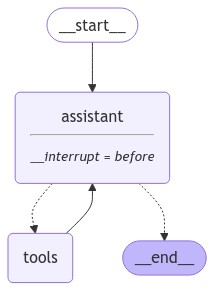

In [3]:
from IPython.display import Image, display

from langchain_core.messages.base import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")


# Node
def assistant(state: MessagesState) -> dict[str, list[BaseMessage]]:
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
# assistantノードの前にブレークポイントを設定
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

実行してみましょう！

チャットモデルが応答する前にグラフが中断されるのがわかります。

訳注: もし中断なしで最後まで実行されるならば、`tools` が呼ばれて、計算結果が入っているはずです。

In [6]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [5]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='363a3b71-6339-4f51-9a99-207c3102ea06')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef816e7-781a-6c76-8000-7cbf0cd37ffa'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}}, created_at='2024-10-03T10:01:32.314726+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef816e7-7816-60dc-bfff-9caefe9ee022'}}, tasks=(PregelTask(id='f4b8af1c-6e7b-ab3a-ffb1-8ca645b285c1', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None),))

これで、状態の更新を直接適用できるようになりました。

`messages` キーの更新には `add_messages` reducerを使用することを覚えておいてください：

* 既存のメッセージを上書きしたい場合は、メッセージの `id` を指定します。
* 単にメッセージのリストに追加したい場合は、以下のように `id` を指定せずにメッセージを渡します。


In [6]:
graph.update_state(
    thread,
    {"messages": [HumanMessage(content="No, actually multiply 3 and 3!")]},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef81673-8586-6828-8001-98ae6c4c88f5'}}

さあ、見てみましょう。

新しいメッセージで `update_state` を呼びました。

`add_messages` reducerはこれをstate keyの `messages` に追加します。


In [7]:
new_state = graph.get_state(thread).values
for m in new_state["messages"]:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No, actually multiply 3 and 3!


さて、エージェントを進めましょう。単純に `None` を渡して、現在の状態から進めるようにします。

現在の状態を出力し、残りのノードを実行します。


In [8]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

No, actually multiply 3 and 3!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_zwifQpJf4FqrhCvcFNyXHOow)
 Call ID: call_zwifQpJf4FqrhCvcFNyXHOow
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


`assistant` に戻ると、`breakpoint` があります。

再び `None` を渡して次に進みます。


In [9]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

9
================================== Ai Message ==================================

The result of multiplying 3 and 3 is 9.


### Editing graph state in Studio

--

**⚠️ 注意**

*Studioの実行には現在Macが必要です。



*また、このノートブックをCoLabで実行している場合は、このステップをスキップしてください。 *

--

`module-3/studio/langgraph.json`に設定された`module-3/studio/agent.py`を使う `agent`をStudio UIでロードしてみましょう。

### LangGraph APIでグラフの状態を編集する

SDK経由でエージェントとやりとりできます。

![Screenshot 2024-08-26 at 9.59.19 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf2fbfb576f8e53ed930_edit-state-human-feedback1.png)

StudioからローカルデプロイのURLを取得してみましょう。

LangGraph API [グラフ状態の編集をサポート](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_edit_state/#initial-invocation).


In [ ]:
from IPython import get_ipython
import platform

if "google.colab" in str(get_ipython()) or platform.system() != "Darwin":
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab or requires a Mac")

In [9]:
from langgraph_sdk import get_client

client = get_client(url="http://localhost:56091")

私たちのエージェントは `assistant/agent.py` で定義されています。

コードを見てみると、ブレークポイントが *無い* ことがわかります！

もちろん、`agent.py` に追加することもできますが、API の素晴らしい機能の1つは、ブレークポイントを渡すことができることです！

ここでは、`interrupt_before=["assistant"]`を渡しています。




In [10]:
initial_input = {"messages": "Multiply 2 and 3"}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=initial_input,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get("messages", [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '882dabe4-b877-4d71-bd09-c34cb97c4f46', 'example': False}
--------------------------------------------------


現在の状態を取得します

In [11]:
current_state = await client.threads.get_state(thread["thread_id"])
current_state

{'values': {'messages': [{'content': 'Multiply 2 and 3',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '882dabe4-b877-4d71-bd09-c34cb97c4f46',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': 'a71c0b80-a679-57cb-aa59-a1655b763480',
   'name': 'assistant',
   'error': None,
   'interrupts': [],
   'state': None}],
 'metadata': {'step': 0,
  'run_id': '1ef6a41c-ea63-663f-b3e8-4f001bf0bf53',
  'source': 'loop',
  'writes': None,
  'parents': {},
  'user_id': '',
  'graph_id': 'agent',
  'thread_id': 'a95ffa54-2435-4a47-a9da-e886369ca8ee',
  'created_by': 'system',
  'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca'},
 'created_at': '2024-09-03T22:13:54.466695+00:00',
 'checkpoint_id': '1ef6a41c-ead7-637b-8000-8c6a7b98379e',
 'parent_checkpoint_id': '1ef6a41c-ead3-637d-bfff-397ebdb4f2ea'}

状態の最後のメッセージを見ることができます。

In [12]:
last_message = current_state["values"]["messages"][-1]
last_message

{'content': 'Multiply 2 and 3',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': '882dabe4-b877-4d71-bd09-c34cb97c4f46',
 'example': False}

編集することができます！

In [13]:
last_message["content"] = "No, actually multiply 3 and 3!"
last_message

{'content': 'No, actually multiply 3 and 3!',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': '882dabe4-b877-4d71-bd09-c34cb97c4f46',
 'example': False}

In [14]:
last_message

{'content': 'No, actually multiply 3 and 3!',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': '882dabe4-b877-4d71-bd09-c34cb97c4f46',
 'example': False}

先ほど言ったように、`messages` キーの更新には同じ `add_messages` reducerを使用することを覚えておいてください。

既存のメッセージを上書きしたい場合は、メッセージの `id` を指定します。

ここではそうしました。メッセージの `content` だけを変更しました。


In [15]:
await client.threads.update_state(thread["thread_id"], {"messages": last_message})

{'configurable': {'thread_id': 'a95ffa54-2435-4a47-a9da-e886369ca8ee',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef6a41d-cc8e-6979-8001-8c7c283b636c'},
 'checkpoint_id': '1ef6a41d-cc8e-6979-8001-8c7c283b636c'}

ここで、`None`を渡して再開します。

In [16]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get("messages", [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'No, actually multiply 3 and 3!', 'additional_kwargs': {'additional_kwargs': {}, 'response_metadata': {}, 'example': False}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '882dabe4-b877-4d71-bd09-c34cb97c4f46', 'example': False}
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_vi16je2EIikHuT7Aue2sd1qd', 'function': {'arguments': '{"a":3,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai', 'name': None, 'id': 'run-775b42f7-0590-4c54-aaeb-78599b1f12d2', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 3, 'b': 3}, 'id': 'call_vi16je2EIikHuT7Aue2sd1qd', 'type

予想通り、tool call の結果は `9` です。

In [17]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get("messages", [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': '9', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '226bfbad-0cea-4900-80c5-761a62bd4bc1', 'tool_call_id': 'call_vi16je2EIikHuT7Aue2sd1qd', 'artifact': None, 'status': 'success'}
--------------------------------------------------
Receiving new event of type: values...
{'content': 'The result of multiplying 3 by 3 is 9.', 'additional_kwargs': {}, 'response_metadata': {'finish_reason': 'stop', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai', 'name': None, 'id': 'run-859bbf47-9f35-4e71-ae98-9d93ee49d16c', 'example': False, 'tool_calls': [], 'invalid_tool_calls': [], 'usage_metadata': None}
--------------------------------------------------


## ユーザー入力を待つ

このように、ブレークポイントの後にエージェントの状態を編集できることは明らかです。

では、この状態更新を行うために、人間のフィードバックを許可したい場合はどうすればよいでしょうか？

エージェントの中に、[人間のフィードバックのプレースホルダとして機能する](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/wait-user-input/#setup) ノードを追加します。

この `human_feedback` ノードにより、ユーザは状態に直接フィードバックを追加することができます。

`humanan_feedback` ノードの前に `interrupt_before` を使ってブレークポイントを指定します。

checkpointerを設定して、このノードまでのグラフの状態を保存します。



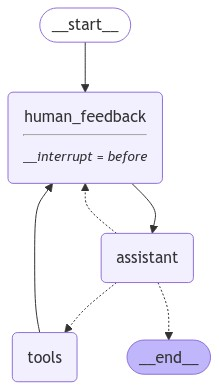

In [10]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")


# no-op node that should be interrupted on
def human_feedback(state: MessagesState):
    pass


# Assistant node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine the control flow
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

ユーザーからのフィードバックを得ます。

先ほどと同じように、`.update_state` を使ってグラフの状態を更新します。

`as_node="human_feedback"` パラメータを使用して、この状態の更新を指定されたノード `human_feedback` として適用します。




In [14]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "5"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

# Get user input
user_input = input("Tell me how you want to update the state: ")

# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"messages": user_input}, as_node="human_feedback")

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

no mutiply 3 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_u7uAk56O4zvy0CgD3uRwl1vq)
 Call ID: call_u7uAk56O4zvy0CgD3uRwl1vq
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


訳注: 一つ上のセルで、"no mutiply 3 and 3" というのが、中断時に人間が入力したテキストです。

In [15]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

9
================================== Ai Message ==================================

The result of multiplying 3 and 3 is 9. If you need further assistance, feel free to ask!
